In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import math
import contextily as ctx

In [8]:
params = {'figure.figsize': [10,10], "xtick.bottom": False, "xtick.labelbottom": False, "ytick.left": False, "ytick.labelleft": False}
plt.rcParams.update(params)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


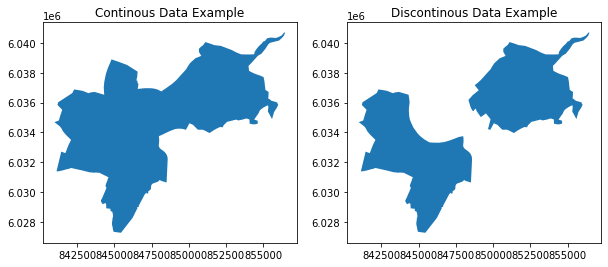

In [3]:
#Download city's .shp file
data_to_plot = gpd.read_file('Example Map Data (PW_PolitischeWahlkreise)/PolitischeWahlkreise.shp')

#Rememeber to be consistent with which epsg is being used
data_to_plot = data_to_plot.to_crs(epsg=3857)

#Make continous example and combine geometries with gpd.dissolve
example_data_continous = data_to_plot
example_data_continous["common joiner"] = [0] * len(example_data_continous)
example_data_continous = example_data_continous.dissolve(by="common joiner")

#Make an example with two areas of disjoined data
example_data_dis_continous = data_to_plot[data_to_plot["KUERZEL"] != "K"]
example_data_dis_continous["common joiner"] = [0] * len(example_data_dis_continous)
example_data_dis_continous = example_data_dis_continous.dissolve(by="common joiner")

fig, ax = plt.subplots(1,2)

example_data_continous.plot(ax=ax[0])
ax[0].set_title("Continous Data Example")

example_data_dis_continous.plot(ax=ax[1])
ax[1].set_title("Discontinous Data Example");

#Save the xtick and ytick range for later
continous_ranges = (ax[0].get_xlim(), ax[0].get_ylim())
dis_continous_ranges = (ax[1].get_xlim(), ax[1].get_ylim())

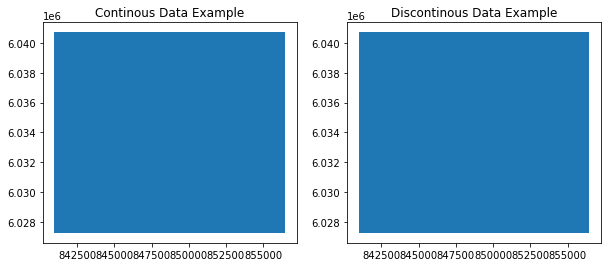

In [4]:
#Calculate the scale of buffer required to guarantee a complete mask of the shape
fig, ax = plt.subplots(1,2)

continous_envelope = example_data_continous.geometry.envelope
continous_envelope.plot(ax=ax[0])
ax[0].set_title("Continous Data Example")

dis_continous_envelope = example_data_dis_continous.geometry.envelope
dis_continous_envelope.plot(ax=ax[1])
ax[1].set_title("Discontinous Data Example");

#The minimum distance of buffer required to guarantee a total mask 
#(when considering discontinous data) is the diagonal of the envelope

In [5]:
#Calculate diagonal length using envelope's coordinates for continous example
continous_coods = continous_envelope.iloc[0].bounds
x_span = continous_coods[2] - continous_coods[0]
y_span = continous_coods[3] - continous_coods[1]

#Use pythagoras and divide by two (buffer expands from all points 
#so only half the width is required to cover the plot)
continous_buffer_length = math.sqrt((x_span**2) + (y_span**2)) / 2



#And now for the discontinous example
dis_continous_coods = dis_continous_envelope.iloc[0].bounds
x_span = dis_continous_coods[2] - dis_continous_coods[0]
y_span = dis_continous_coods[3] - dis_continous_coods[1]

#Use pythagoras
dis_continous_buffer_length = math.sqrt((x_span**2) + (y_span**2)) / 2





display(continous_buffer_length)
display(dis_continous_buffer_length)


10261.659879273002

10261.659879273002

In [6]:
#Make the mask for each example
mask_continous = example_data_continous.copy()
mask_continous["geometry"] = example_data_continous.geometry.buffer(continous_buffer_length)
mask_continous = gpd.overlay(mask_continous, example_data_continous, how="difference")

mask_dis_continous = example_data_dis_continous.copy()
mask_dis_continous["geometry"] = example_data_dis_continous.geometry.buffer(dis_continous_buffer_length)
mask_dis_continous = gpd.overlay(mask_dis_continous, example_data_dis_continous, how="difference")

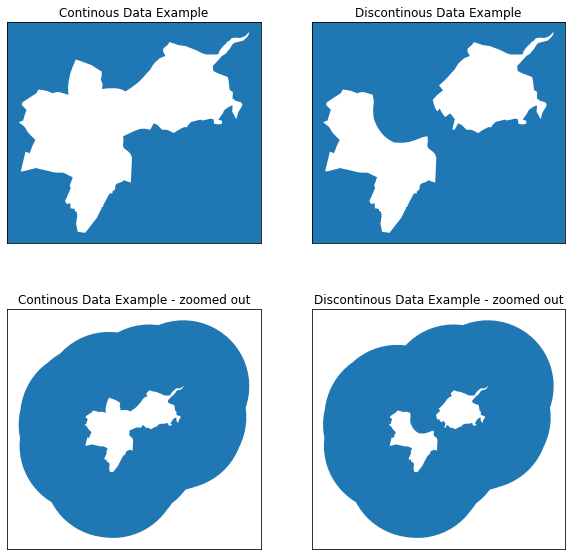

In [9]:
fig, ax = plt.subplots(2,2)


#Plot the mask using the original zoom
mask_continous.plot(ax=ax[0][0])
ax[0][0].set_xlim(continous_ranges[0])
ax[0][0].set_ylim(continous_ranges[1])
ax[0][0].set_title("Continous Data Example")

mask_dis_continous.plot(ax=ax[0][1])
ax[0][1].set_xlim(dis_continous_ranges[0])
ax[0][1].set_ylim(dis_continous_ranges[1])
ax[0][1].set_title("Discontinous Data Example");


#Plot the mask zoomed-out
mask_continous.plot(ax=ax[1][0])
ax[1][0].set_title("Continous Data Example - zoomed out")

mask_dis_continous.plot(ax=ax[1][1])
ax[1][1].set_title("Discontinous Data Example - zoomed out");

plt.savefig("Automated_width_of_buffer_created.png", dpi=500)

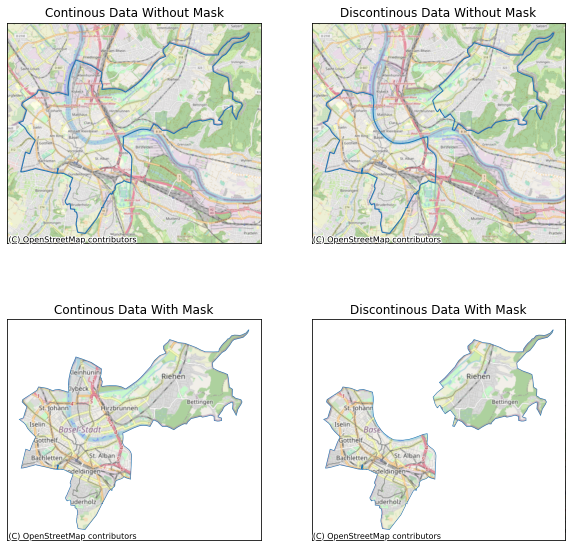

In [10]:
fig, ax = plt.subplots(2,2)


#Plot using background image without the mask
#Continous
example_data_continous.plot(ax=ax[0][0], facecolor="none", edgecolor='#1f77b4')
ctx.add_basemap(ax[0][0], source=ctx.providers.OpenStreetMap.Mapnik)
ax[0][0].set_title("Continous Data Without Mask")

#Discontinous
example_data_dis_continous.plot(ax=ax[0][1], facecolor="none", edgecolor='#1f77b4')
ctx.add_basemap(ax[0][1], source=ctx.providers.OpenStreetMap.Mapnik)
ax[0][1].set_title("Discontinous Data Without Mask")


#Plot using background image WITH the mask
#Continous
example_data_continous.plot(ax=ax[1][0], facecolor="none", edgecolor='#1f77b4')
mask_continous.plot(ax=ax[1][0], color='white')

ctx.add_basemap(ax[1][0], source=ctx.providers.OpenStreetMap.Mapnik)
ax[1][0].set_title("Continous Data With Mask")
ax[1][0].set_xlim(continous_ranges[0])
ax[1][0].set_ylim(continous_ranges[1])

#Discontinous
example_data_dis_continous.plot(ax=ax[1][1], facecolor="none", edgecolor='#1f77b4')
mask_dis_continous.plot(ax=ax[1][1], color='white')

ctx.add_basemap(ax[1][1], source=ctx.providers.OpenStreetMap.Mapnik)
ax[1][1].set_title("Discontinous Data With Mask")
ax[1][1].set_xlim(dis_continous_ranges[0])
ax[1][1].set_ylim(dis_continous_ranges[1])

plt.savefig("Example_output_with_and_without_mask.png", dpi=500)